<a href="https://colab.research.google.com/github/williamtheodoruswijaya/mteb-auto-labeller/blob/main/workflow/mteb_autolabeller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

import warnings
warnings.filterwarnings('ignore')

# Data Loading

### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download Dataset from Google Drive

In [3]:
%%capture

!pip install gdown

In [4]:
import gdown

file_id = '1WFPrMvJ9tVBP3_ulCdJn40NPpHS2r8vA'
output_filename = 'dataset.csv'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output_filename, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1WFPrMvJ9tVBP3_ulCdJn40NPpHS2r8vA
To: /content/dataset.csv
100%|██████████| 28.8M/28.8M [00:00<00:00, 41.2MB/s]


'dataset.csv'

### Load Dataset

In [5]:
df = pd.read_csv('./dataset.csv')

df.head()

,id,code,content,image_url,latitude,longitude,status,category,zone,village,district,city,province,created_at
0,b0906c9a-e3e3-410b-b918-1fa77438563b,JK2401070247,Saya membuat laporan EM231211BDKB tanggal 12 D...,https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.176120,106.868300,Selesai,Gangguan dan Kebisingan,SATUAN POLISI PAMONG PRAJA KOTA ADM JAKARTA PUSAT,CEMPAKA PUTIH TIMUR,CEMPAKA PUTIH,JAKARTA PUSAT,DKI JAKARTA,2024-01-07T07:10:58.900Z
1,800d8988-3036-4360-b292-77f5ba6bb946,JK2401050479,"Jalan amblas, sudah banyak korban. \nAkibat pe...",https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.281803,106.771948,Selesai,Jalan,SUDIN SUMBER DAYA AIR JAKARTA SELATAN,PONDOK PINANG,KEBAYORAN LAMA,JAKARTA SELATAN,DKI JAKARTA,2024-01-05T15:27:53.040Z
2,ee1af07a-dc67-4846-9661-ea0c20d1ef08,JK2401100152,"terdapat lubang cukup dalam, atas perhatian da...",https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.223766,106.823427,Selesai,Jalan,UNIT PERALATAN DAN PERBEKALAN BINA MARGA,KARET KUNINGAN,SETIA BUDI,JAKARTA SELATAN,DKI JAKARTA,2024-01-10T02:38:47.276Z
3,00c83eee-78b5-4749-af46-d17a5e388aa8,JK2401070277,Segera tindak lanjuti masalah hujan lebat dari...,https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.302330,106.816300,Selesai,Penanganan Banjir,KELURAHAN RAGUNAN,RAGUNAN,PASAR MINGGU,JAKARTA SELATAN,DKI JAKARTA,2024-01-07T08:08:15.210Z
4,ca8a4b6f-21a8-4228-b428-8ad57042775d,JK2401070267,Mohon permohonan peninggian jembatan dan pemba...,https://s3-jaki.jakarta.go.id/jaki/report/medi...,-6.266710,106.832800,Selesai,Jalan,KELURAHAN KALIBATA,KALIBATA,PANCORAN,JAKARTA SELATAN,DKI JAKARTA,2024-01-07T07:38:14.759Z


### Take the only relevants column

In [6]:
df.index = df['id']
df = df[['content', 'category', 'created_at', 'longitude', 'latitude']]

df.head()

,content,category,created_at,longitude,latitude
id,,,,,
b0906c9a-e3e3-410b-b918-1fa77438563b,Saya membuat laporan EM231211BDKB tanggal 12 D...,Gangguan dan Kebisingan,2024-01-07T07:10:58.900Z,106.868300,-6.176120
800d8988-3036-4360-b292-77f5ba6bb946,"Jalan amblas, sudah banyak korban. \nAkibat pe...",Jalan,2024-01-05T15:27:53.040Z,106.771948,-6.281803
ee1af07a-dc67-4846-9661-ea0c20d1ef08,"terdapat lubang cukup dalam, atas perhatian da...",Jalan,2024-01-10T02:38:47.276Z,106.823427,-6.223766
00c83eee-78b5-4749-af46-d17a5e388aa8,Segera tindak lanjuti masalah hujan lebat dari...,Penanganan Banjir,2024-01-07T08:08:15.210Z,106.816300,-6.302330
ca8a4b6f-21a8-4228-b428-8ad57042775d,Mohon permohonan peninggian jembatan dan pemba...,Jalan,2024-01-07T07:38:14.759Z,106.832800,-6.266710


# Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53898 entries, b0906c9a-e3e3-410b-b918-1fa77438563b to e18199f0-79be-42ae-8402-6ed5d108ddc0
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   content     53898 non-null  object 
 1   category    53898 non-null  object 
 2   created_at  53898 non-null  object 
 3   longitude   53898 non-null  float64
 4   latitude    53898 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


### Check for Copy-paste Spammer

In [8]:
df['content'].duplicated().sum()

np.int64(13234)

In [9]:
df[df['content'].duplicated()].head()

,content,category,created_at,longitude,latitude
id,,,,,
96f3308d-59f6-4297-ad8c-dda0218d7553,"kabel internet menjuntai dan berantakan, tolon...",Jaringan Listrik,2024-01-07T11:21:09.230Z,106.914700,-6.227400
4d6f9bbe-3050-4eae-ba97-a1348867b780,"kabel internet menjuntai dan berantakan, tolon...",Jaringan Listrik,2024-01-07T11:22:51.896Z,106.916100,-6.226470
34783036-df1d-4184-b84f-7b50a6ab3a03,"kabel internet menjuntai dan berantakan, tolon...",Jaringan Listrik,2024-01-07T11:19:34.457Z,106.914600,-6.227520
ca536f86-0af9-43e3-878c-668386791b52,"kabel internet menjuntai dan berantakan, tolon...",Jaringan Listrik,2024-01-07T11:20:11.490Z,106.914600,-6.227470
8516b374-2b72-4d5e-b981-b7589e255ba3,PKL liar menggunakan fasum untuk berdagang\n\n...,PKL Liar,2024-01-01T06:43:18.627Z,106.793909,-6.166111


Oke, data kita so-far banyak spammer copy-paste. Jadi kita harus filtering spammer-spammer ini.

### Data Distributions

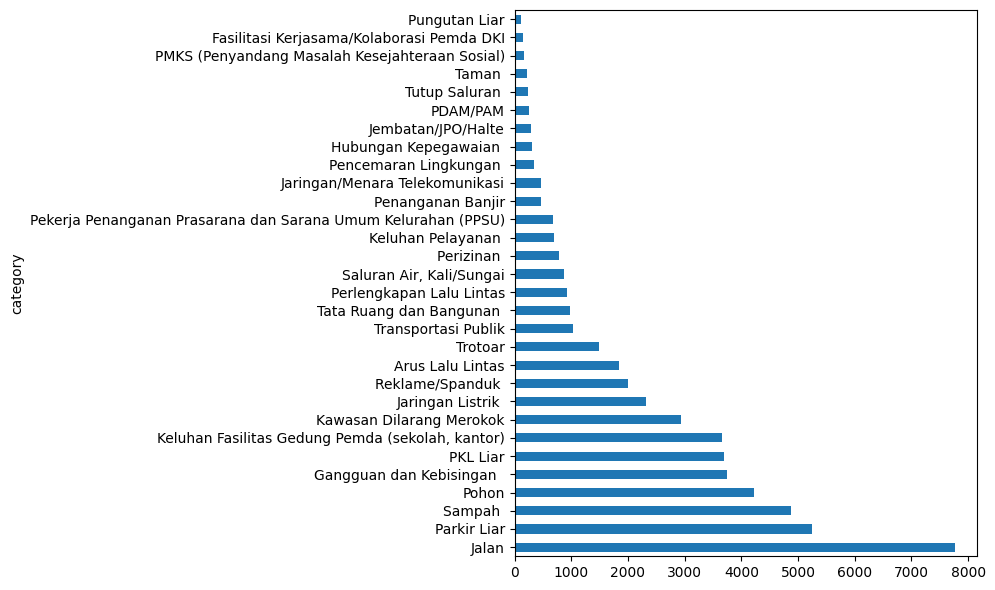

In [10]:
plt.figure(figsize=(10, 6))
df['category'].value_counts().head(30).plot(kind='barh')
plt.tight_layout()
plt.show()

Disini distribusi kategori cenderung tidak imbang, sehingga kalau kita pakai metode supervised learning buat generate label based on text, model bakal cenderung bias ke arah label mayoritas. Makanya, perlu approach yang lebih efektif buat handling bias ini, jadi kita bakal pakai metode unsupervised buat generate label bersamaan dengan hidden sub-topic based on text laporan yang dibuat pada kolom 'content'.

### Noise Analysis

- Word Count Analysis of each content (panjang rata-rata laporan warga buat semua kategori)

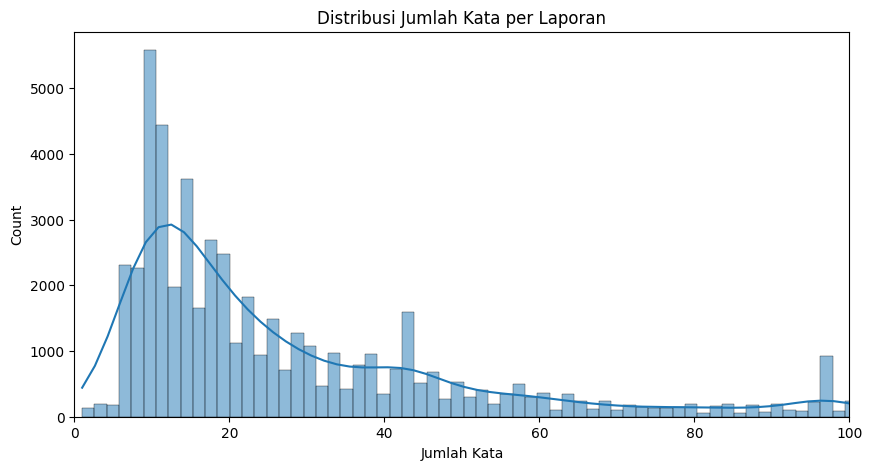

In [11]:
df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], kde=True)
plt.title('Distribusi Jumlah Kata per Laporan')
plt.xlabel('Jumlah Kata')
plt.xlim(0, 100)
plt.show()

- Summary Statistics of Word Count

In [12]:
df['word_count'].describe().T

,word_count
count,53898.000000
mean,33.756373
std,37.195414
min,1.000000
25%,12.000000
50%,20.000000
75%,42.000000
max,328.000000


Kita bisa liat ada noise di data yang ditunjukkan oleh adanya laporan yang hanya tersusun dari 1 kata aja.

In [13]:
df[df['word_count'] == 1]['content']

,content
id,
0afe224b-40bd-4be6-94d9-376385d23c48,Padam............................................
38db9e7a-aa9a-4b16-b393-4ead509ff083,Amblazzzzzzzzzz..................................
f21dfe10-be87-4f34-be06-780789f012a1,corli............................................
096b8c30-3ebf-4c9a-8917-4f8e115b8f82,#sampah
a7ea39ae-0248-4603-8968-bc26be46c3f7,ftijjhhdswehjkklluewawwyjjfdswwfghuuuuijjkkkkk...
85560c54-3ecc-48d1-9422-646a9e1ead06,sampahhhhhh......................................
33eda650-90e6-4b35-b5ac-747d5d6c5b8e,ghsiiejdjdjdjdjdjdkdkddkhshsjsjakasklssusjjsnx...
c170d72a-03de-4a31-af06-c717eb108284,odbdidfnrkgkggjfksjsbsvwuabsoaxvheekssnsjsisna...
2e356bcd-64e4-4f49-825b-9085269f6278,vfhhhderghhgrethheethhheerrthxcjjnvxwsshjnbsss...


Diatas terlihat bahwa laporan-laporan yang dibuat adalah laporan yang basically bisa kita anggap sebagai noise karena laporan jenis ini tidak akan memiliki `semantics context` yang cukup buat model kita untuk bekerja secara efektif. Jadi, kita harus ngelakuin filtering di bagian data preprocessing terhadap data dengan word count yang sedikit.

# Data Preprocessing

In [14]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

### regex

In [15]:
def clean_text(text):
    # Ubah jadi lowercase
    text = str(text).lower()

    # Hapus URL
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Hapus Mentions & Hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Hapus Emoji & Simbol Aneh (ganti dgn spasi)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [16]:
df['clean_content'] = df['content'].apply(clean_text)

### Delete Copy-Paste Spammer

In [17]:
initial_count = len(df)
df = df.drop_duplicates(subset=['clean_content'])

In [18]:
df['content'].duplicated().sum()

np.int64(0)

### Delete Noise (Laporan warga yang cuman 1 kata (ga-detailed))

In [19]:
df = df[df['word_count'] >= 4].copy()

In [20]:
df['word_count'].describe()

,word_count
count,39816.000000
mean,29.596419
std,32.305215
min,4.000000
25%,12.000000
50%,19.000000
75%,34.000000
max,328.000000


### Simpen ke .csv biar cepet kalau mau re-training notebook.

In [21]:
df.columns

Index(['content', 'category', 'created_at', 'longitude', 'latitude',
       'word_count', 'clean_content'],
      dtype='object')

In [22]:
df = df[['content', 'category', 'created_at', 'longitude', 'latitude']]

df.to_csv('cleaned_dataset.csv', index=False)

### Final Results on Cleaned Dataset

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39816 entries, b0906c9a-e3e3-410b-b918-1fa77438563b to e18199f0-79be-42ae-8402-6ed5d108ddc0
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   content     39816 non-null  object 
 1   category    39816 non-null  object 
 2   created_at  39816 non-null  object 
 3   longitude   39816 non-null  float64
 4   latitude    39816 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.8+ MB


Setelah Filtering dkk, dataset kita dari 53898 jadi sisa 39816 baris.

# Fine-Tuning (E5)

In [40]:
%%capture

!pip install sentence-transformers

In [53]:
import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, models, losses, datasets
import gc
import os

# biar ga diminta Login pas Fine Tuning
os.environ["WANDB_MODE"] = "disabled"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [54]:
gc.collect()
torch.cuda.empty_cache()

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

- Reload cleaned csv

In [56]:
df = pd.read_csv('cleaned_dataset.csv')

df.head()

,content,category,created_at,longitude,latitude
0,Saya membuat laporan EM231211BDKB tanggal 12 D...,Gangguan dan Kebisingan,2024-01-07T07:10:58.900Z,106.868300,-6.176120
1,"Jalan amblas, sudah banyak korban. \nAkibat pe...",Jalan,2024-01-05T15:27:53.040Z,106.771948,-6.281803
2,"terdapat lubang cukup dalam, atas perhatian da...",Jalan,2024-01-10T02:38:47.276Z,106.823427,-6.223766
3,Segera tindak lanjuti masalah hujan lebat dari...,Penanganan Banjir,2024-01-07T08:08:15.210Z,106.816300,-6.302330
4,Mohon permohonan peninggian jembatan dan pemba...,Jalan,2024-01-07T07:38:14.759Z,106.832800,-6.266710


In [57]:
X = df['content'].tolist()

### TSDAE (Transformer-based Sequential Denoising Auto-Encoder)

Denoising AutoEncoder (Model belajar menebak kalimat asli dari kalimat yang dirusak dengan diberi noise)

- Load Model

In [62]:
word_embedding_model = models.Transformer('indobenchmark/indobert-base-p1', max_seq_length=128)

- Tambahin Pooling Layer

In [63]:
# Tambahkan Pooling Layer (Wajib buat IndoBERT biar jadi vektor kalimat)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

In [64]:
# Gabungkan jadi satu model siap pakai
model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device=device)

- Create a training data (Convert sentences into Sentence_transformers Input Example Data Types)

In [65]:
train_dataset = datasets.DenoisingAutoEncoderDataset(X)

- Convert it into DataLoader

In [66]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

- Specify Loss Function: TSDAE menggunakan DenoisingAutoEncoderLoss

In [67]:
train_loss = losses.DenoisingAutoEncoderLoss(
    model,
    tie_encoder_decoder=True
)

Some weights of BertLMHeadModel were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.b

In [68]:
# Start Fine-Tuning (Retraining Pretrained IndoBERT Model into our Dataset)
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    weight_decay=0,
    scheduler='constantlr',
    optimizer_params={'lr': 3e-5},
    show_progress_bar=True,
    use_amp=True
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,6.052400
1000,4.970900
1500,4.606400
2000,4.396400
2500,4.236400
3000,4.132900
3500,4.013900
4000,3.937600


KeyboardInterrupt: 

# Text Representation

In [ ]:
embeddings = model.encode(
    X,
    batch_size=32,
    show_progress_bar=True,
    device=device,
    convert_to_numpy=True,
    normalize_embeddings=True
)

In [ ]:
# --- 6. SIMPAN HASIL ---
if not os.path.exists('output'):
    os.makedirs('output')

# Simpan embedding & metadata
np.save('output/embeddings_indobert.npy', embeddings)
df.to_csv('output/metadata_laporan.csv', index=False)

print(f"\nSUKSES! Shape Embedding: {embeddings.shape}")
print("File tersimpan: output/embeddings_indobert.npy")
print("Siap lanjut ke tahap Semantic Graph & Clustering!")